# PEFT 库 LoRA 实战 - OpenAI Whisper-large-v2

本教程使用 LoRA 在`OpenAI Whisper-large-v2`模型上实现`语音识别(ASR)`任务的微调训练。

同时，我们还结合了`int8` 量化进一步降低训练过程资源开销，同时保证了精度几乎不受影响。

![LoRA](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/peft/lora_diagram.png)

本教程主要训练流程如下：
- 全局参数设置
- 数据准备
    - 下载数据集：训练、验证和评估集
    - 预处理数据：降采样、移除不必要字段等
    - 数据抽样（演示需要）
    - 应用数据集处理（`Dataset.map`）
    - 自定义语音数据处理器
- 模型准备
    - 加载和处理 `int8` 精度 Whisper-Large-v2 模型
    - LoRA Adapter 参数配置
    - 实例化 PEFT Model：`peft_model = get_peft_model(model, config)`
- 模型训练
    - 训练参数配置 Seq2SeqTrainingArguments
    - 实例化训练器 Seq2SeqTrainer
    - 训练模型
    - 保存模型
- 模型推理
    - 使用 `PeftModel` 加载 LoRA 微调后 Whisper 模型
    - 使用 `Pipeline API` 部署微调后 Whisper 实现中文语音识别任务

## 全局参数设置

In [1]:
model_name_or_path = "openai/whisper-large-v2"
model_dir = "models/whisper-large-v2-asr-int8"

language = "Chinese (China)"
language_abbr = "zh-CN"
task = "transcribe"
dataset_name = "mozilla-foundation/common_voice_11_0"

batch_size=64

## 数据准备

### 下载数据集 Common Voice

Common Voice 11.0 数据集包含许多不同语言的录音，总时长达数小时。

本教程以中文数据为例，展示如何使用 LoRA 在 Whisper-large-v2 上进行微调训练。

首先，初始化一个DatasetDict结构，并将训练集（将训练+验证拆分为训练集）和测试集拆分好，按照中文数据集构建配置加载到内存中：

In [2]:
from datasets import load_dataset, DatasetDict

common_voice = DatasetDict()

common_voice["train"] = load_dataset(dataset_name, language_abbr, split="train", trust_remote_code=True)
common_voice["validation"] = load_dataset(dataset_name, language_abbr, split="validation", trust_remote_code=True)

common_voice["train"][0]

/home/wangfuxin/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'client_id': '95368aab163e0387e4fd4991b4f2d8ccfbd4364bf656c860230501fd27dcedf087773e4695a6cf5de9c4f1d406d582283190d065cdfa36b0e2b060cffaca977e',
 'path': '/home/wangfuxin/.cache/huggingface/datasets/downloads/extracted/f49b6d207644d533c11effa31425d23418b5da14ab01d7f45a24d6e0f199344b/zh-CN_train_0/common_voice_zh-CN_33211332.mp3',
 'audio': {'path': '/home/wangfuxin/.cache/huggingface/datasets/downloads/extracted/f49b6d207644d533c11effa31425d23418b5da14ab01d7f45a24d6e0f199344b/zh-CN_train_0/common_voice_zh-CN_33211332.mp3',
  'array': array([-6.82121026e-13, -2.27373675e-12, -2.27373675e-12, ...,
          1.21667399e-05,  3.23003678e-06, -2.43066324e-07]),
  'sampling_rate': 48000},
 'sentence': '性喜温暖润湿气候且耐寒。',
 'up_votes': 2,
 'down_votes': 0,
 'age': '',
 'gender': '',
 'accent': '',
 'locale': 'zh-CN',
 'segment': ''}

In [3]:
common_voice

DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 29056
    })
    validation: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 10581
    })
})

## 预处理训练数据集


In [4]:
from transformers import AutoFeatureExtractor, AutoTokenizer, AutoProcessor

# 从预训练模型加载特征提取器
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name_or_path)

# 从预训练模型加载分词器，可以指定语言和任务以获得最适合特定需求的分词器配置
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, language=language, task=task)

# 从预训练模型加载处理器，处理器通常结合了特征提取器和分词器，为特定任务提供一站式的数据预处理
processor = AutoProcessor.from_pretrained(model_name_or_path, language=language, task=task)

/home/wangfuxin/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### 移除数据集中不必要的字段

In [5]:
common_voice = common_voice.remove_columns(
    ["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes"]
)

In [6]:
common_voice["train"][0]

{'audio': {'path': '/home/wangfuxin/.cache/huggingface/datasets/downloads/extracted/f49b6d207644d533c11effa31425d23418b5da14ab01d7f45a24d6e0f199344b/zh-CN_train_0/common_voice_zh-CN_33211332.mp3',
  'array': array([-6.82121026e-13, -2.27373675e-12, -2.27373675e-12, ...,
          1.21667399e-05,  3.23003678e-06, -2.43066324e-07]),
  'sampling_rate': 48000},
 'sentence': '性喜温暖润湿气候且耐寒。'}

#### 降采样音频数据

查看`common_voice` 数据集介绍，你会发现其音频是以48kHz的采样率进行采样的.

而`Whisper`模型是在16kHZ的音频输入上预训练的，因此我们需要将音频输入降采样以匹配模型预训练时使用的采样率。

通过在音频列上使用`cast_column`方法，并将`sampling_rate`设置为16kHz来对音频进行降采样。

下次调用时，音频输入将实时重新取样：

In [7]:
from datasets import Audio

common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))

In [8]:
# sampling_rate 从 48KHZ 降为 16KHZ
common_voice["train"][0]

{'audio': {'path': '/home/wangfuxin/.cache/huggingface/datasets/downloads/extracted/f49b6d207644d533c11effa31425d23418b5da14ab01d7f45a24d6e0f199344b/zh-CN_train_0/common_voice_zh-CN_33211332.mp3',
  'array': array([ 5.09317033e-11, -7.27595761e-12, -6.54836185e-11, ...,
         -5.96661994e-06,  2.71382887e-05,  1.29687978e-05]),
  'sampling_rate': 16000},
 'sentence': '性喜温暖润湿气候且耐寒。'}

### 整合以上数据处理为一个函数

该数据预处理函数应该包括：
- 通过加载音频列将音频输入重新采样为16kHZ。
- 使用特征提取器从音频数组计算输入特征。
- 将句子列标记化为输入标签。

In [9]:
def prepare_dataset(batch):
    audio = batch["audio"]
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

### 数据抽样（演示需要）

在 Whisper-Large-v2 上使用小规模数据进行演示训练，保持以下训练参数不变（batch_size=64）。

使用 640 个样本训练，320个样本验证和评估，恰好使得1个 epoch 仅需10 steps 即可完成训练。

（在 NVIDIA T4 上需要10-15分钟）

In [10]:
small_common_voice = DatasetDict()

small_common_voice["train"] = common_voice["train"].shuffle(seed=16).select(range(640))
small_common_voice["validation"] = common_voice["validation"].shuffle(seed=16).select(range(320))

In [11]:
small_common_voice

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 640
    })
    validation: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 320
    })
})

### 如果全量训练，则使用完整数据代替抽样

#### 云端主机CPU核心8个，设置num_proc=8，运行会造成宕机，丢失远程ssh，恢复后，尝试改为使用 num_proc=4，还是不行，最后放弃该参数。

In [12]:
# 抽样数据处理
# tokenized_common_voice = small_common_voice.map(prepare_dataset)

# 完整数据训练，尝试开启 `num_proc=8` 参数多进程并行处理（如阻塞无法运行，则不使用此参数）
tokenized_common_voice = common_voice.map(prepare_dataset)

CPU占用：

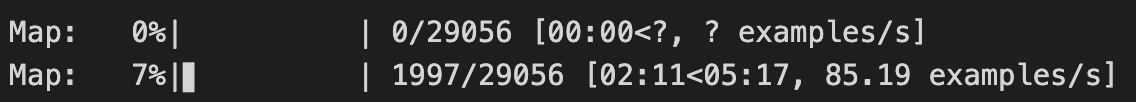

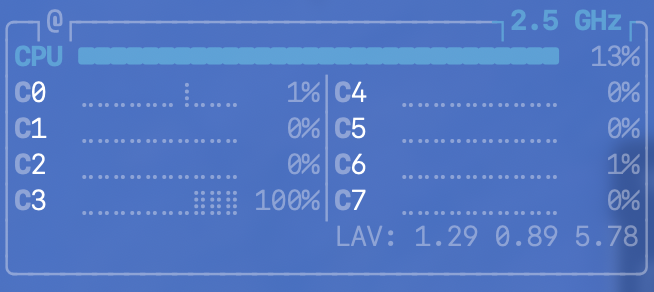

In [13]:
tokenized_common_voice

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence', 'input_features', 'labels'],
        num_rows: 29056
    })
    validation: Dataset({
        features: ['audio', 'sentence', 'input_features', 'labels'],
        num_rows: 10581
    })
})

### 自定义语音数据整理器

定义了一个针对语音到文本（Seq2Seq）模型的自定义数据整理器类，特别适用于输入为语音特征、输出为文本序列的数据集。


这个整理器（`DataCollatorSpeechSeq2SeqWithPadding`）旨在将数据点批量打包，将每个批次中的`attention_mask`填充到最大长度，以保持批处理中张量形状的一致性，并用`-100`替换填充值，以便在损失函数中被忽略。这对于神经网络的高效训练至关重要。

In [14]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

# 定义一个针对语音到文本任务的数据整理器类
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any  # 处理器结合了特征提取器和分词器

    # 整理器函数，将特征列表处理成一个批次
    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # 从特征列表中提取输入特征，并填充以使它们具有相同的形状
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # 从特征列表中提取标签特征（文本令牌），并进行填充
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # 使用-100替换标签中的填充区域，-100通常用于在损失计算中忽略填充令牌
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # 如果批次中的所有序列都以句子开始令牌开头，则移除它
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        # 将处理过的标签添加到批次中
        batch["labels"] = labels

        return batch  # 返回最终的批次，准备好进行训练或评估

In [15]:
# 确认处理器是否正确加载
processor

WhisperProcessor:
- feature_extractor: WhisperFeatureExtractor {
  "chunk_length": 30,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 80,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}

- tokenizer: WhisperTokenizer(name_or_path='openai/whisper-large-v2', vocab_size=50258, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|endoftext|>', '<|startoftranscript|>', '<|en|>', '<|zh|>', '<|de|>', '<|es|>', '<|ru|>', '<|ko|>', '<|fr|>', '<|ja|>', '<|pt|>', '<|tr|>', '<|pl|>', '<|ca|>', '<|nl|>', '<|ar|>', '<|sv|>', '<|it|>', '<|id|>', '<|hi|>', '<|fi|>', '<|vi|>', '<|he|>', '<|uk|

In [16]:
# 用给定的处理器实例化数据整理器
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

## 模型准备

### 加载预训练模型（int8 精度）

使用 `int8 ` 精度加载预训练模型，进一步降低显存需求。

In [17]:
# 确认要加载的模型
print(model_name_or_path)

openai/whisper-large-v2


In [18]:
from transformers import AutoModelForSpeechSeq2Seq

model = AutoModelForSpeechSeq2Seq.from_pretrained(model_name_or_path, load_in_8bit=True, device_map="auto")

/home/wangfuxin/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [19]:
# 设置模型配置中的forced_decoder_ids属性为None
model.config.forced_decoder_ids = None  # 这通常用于指定在解码（生成文本）过程中必须使用的特定token的ID，设置为None表示没有这样的强制要求

# 设置模型配置中的suppress_tokens列表为空
model.config.suppress_tokens = []  # 这用于指定在生成过程中应被抑制（不生成）的token的列表，设置为空列表表示没有要抑制的token

### PEFT 微调前的模型处理

在使用 `peft` 训练 int8 模型之前，需要进行一些预处理：
- 将所有非 `int8` 精度模块转换为全精度（`fp32`）以保证稳定性
- 为输入嵌入层添加一个 `forward_hook`，以启用输入隐藏状态的梯度计算
- 启用梯度检查点以实现更高效的内存训练

使用 `peft` 库预定义的工具函数 `prepare_model_for_int8_training`，便可自动完成以上模型处理工作。

In [20]:
from peft import prepare_model_for_int8_training

model = prepare_model_for_int8_training(model)

/home/wangfuxin/.local/lib/python3.10/site-packages/peft/utils/other.py:141: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


### LoRA Adapter 配置

在 `peft` 中使用`LoRA`非常简捷，借助 `PeftModel`抽象，我们可以快速使用低秩适配器（LoRA）到任意模型。

通过使用 `peft` 中的 `get_peft_model` 工具函数来实现。

#### 关于 LoRA 超参数的说明：
```
MatMul(B,A) * Scaling
Scaling = LoRA_Alpha / Rank
```

In [21]:
from peft import LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model

# 创建一个LoraConfig对象，用于设置LoRA（Low-Rank Adaptation）的配置参数
config = LoraConfig(
    r=4,  # LoRA的秩，影响LoRA矩阵的大小
    lora_alpha=64,  # LoRA适应的比例因子
    # 指定将LoRA应用到的模型模块，通常是attention和全连接层的投影。
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,  # 在LoRA模块中使用的dropout率
    bias="none",  # 设置bias的使用方式，这里没有使用bias
)

### 使用get_peft_model函数和给定的配置来获取一个PEFT模型

In [22]:
model

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 1280)
      (layers): ModuleList(
        (0-31): 32 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear8bitLt(in_features=1280, out_features=1280, bias=False)
            (v_proj): Linear8bitLt(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear8bitLt(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear8bitLt(in_features=1280, out_features=1280, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear8bitLt(in_features=1280, out_features=5120, bias=True)
          (fc2): Linear8bitLt(in_fe

In [23]:
peft_model = get_peft_model(model, config)

In [24]:
# 打印 LoRA 微调训练的模型参数
peft_model.print_trainable_parameters()

trainable params: 1,966,080 || all params: 1,545,271,040 || trainable%: 0.12723204856023188


## 模型训练

#### Seq2SeqTrainingArguments 训练参数

**关于设置训练步数和评估步数**

基于 epochs 设置：

```python
    num_train_epochs=3,  # 训练的总轮数
    evaluation_strategy="epoch",  # 设置评估策略，这里是在每个epoch结束时进行评估
    warmup_steps=50,  # 在训练初期增加学习率的步数，有助于稳定训练
```

基于 steps 设置：

```python
    max_steps=100, # 训练总步数
    evaluation_strategy="steps", 
    eval_steps=25, # 评估步数
```

In [25]:
from transformers import Seq2SeqTrainingArguments
'''
 全量数据集训练，改用基于step的评估策略 wang-fuxin 2025-08-16
 remove_unused_columns=False  # 设置为False以保留所有列，适用于需要使用所有列的情况, 改为True
 fp16=True 启用

# 设置序列到序列模型训练的参数
training_args = Seq2SeqTrainingArguments(
    output_dir=model_dir,  # 指定模型输出和保存的目录
    per_device_train_batch_size=batch_size,  # 每个设备上的训练批量大小
    learning_rate=1e-3,  # 学习率
    max_steps=200, # 训练总步数
    evaluation_strategy="steps", # 设置评估策略，这里是在每个指定步数后进行评估
    eval_steps=25, # 评估步数
    # num_train_epochs=1,  # 训练的总轮数
    # evaluation_strategy="epoch",  # 设置评估策略，这里是在每个epoch结束时进行评估
    # warmup_steps=50,  # 在训练初期增加学习率的步数，有助于稳定训练
    fp16=True,  # 启用混合精度训练，可以提高训练速度，同时减少内存使用
    per_device_eval_batch_size=batch_size,  # 每个设备上的评估批量大小
    generation_max_length=128,  # 生成任务的最大长度
    logging_steps=10,  # 指定日志记录的步骤，用于跟踪训练进度
    remove_unused_columns=True,  # 是否删除不使用的列，以减少数据处理开销
    label_names=["labels"],  # 指定标签列的名称，用于训练过程中
    # evaluation_strategy="steps",
    # eval_steps=25,
)
'''

'\n 全量数据集训练，改用基于step的评估策略 wang-fuxin 2025-08-16\n remove_unused_columns=False  # 设置为False以保留所有列，适用于需要使用所有列的情况, 改为True\n fp16=True 启用\n\n# 设置序列到序列模型训练的参数\ntraining_args = Seq2SeqTrainingArguments(\n    output_dir=model_dir,  # 指定模型输出和保存的目录\n    per_device_train_batch_size=batch_size,  # 每个设备上的训练批量大小\n    learning_rate=1e-3,  # 学习率\n    max_steps=200, # 训练总步数\n    evaluation_strategy="steps", # 设置评估策略，这里是在每个指定步数后进行评估\n    eval_steps=25, # 评估步数\n    # num_train_epochs=1,  # 训练的总轮数\n    # evaluation_strategy="epoch",  # 设置评估策略，这里是在每个epoch结束时进行评估\n    # warmup_steps=50,  # 在训练初期增加学习率的步数，有助于稳定训练\n    fp16=True,  # 启用混合精度训练，可以提高训练速度，同时减少内存使用\n    per_device_eval_batch_size=batch_size,  # 每个设备上的评估批量大小\n    generation_max_length=128,  # 生成任务的最大长度\n    logging_steps=10,  # 指定日志记录的步骤，用于跟踪训练进度\n    remove_unused_columns=True,  # 是否删除不使用的列，以减少数据处理开销\n    label_names=["labels"],  # 指定标签列的名称，用于训练过程中\n    # evaluation_strategy="steps",\n    # eval_steps=25,\n)\n'

In [26]:
'''
全量数据集训练
remove_unused_columns=True
'''

training_args = Seq2SeqTrainingArguments(
    output_dir=model_dir,  # 指定模型输出和保存的目录
    per_device_train_batch_size=batch_size,  # 每个设备上的训练批量大小
    learning_rate=1e-3,  # 学习率
    num_train_epochs=1,  # 训练的总轮数
    evaluation_strategy="epoch",  # 设置评估策略，这里是在每个epoch结束时进行评估
    warmup_steps=50,  # 在训练初期增加学习率的步数，有助于稳定训练
    fp16=True,  # 启用混合精度训练，可以提高训练速度，同时减少内存使用
    per_device_eval_batch_size=batch_size,  # 每个设备上的评估批量大小
    generation_max_length=128,  # 生成任务的最大长度
    logging_steps=10,  # 指定日志记录的步骤，用于跟踪训练进度
    remove_unused_columns=True,  # 是否删除不使用的列，以减少数据处理开销
    label_names=["labels"],  # 指定标签列的名称，用于训练过程中
    # evaluation_strategy="steps",
    # eval_steps=25,
)


### 实例化 Seq2SeqTrainer 训练器

In [27]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=peft_model,
    train_dataset=tokenized_common_voice["train"],
    eval_dataset=tokenized_common_voice["validation"],
    data_collator=data_collator,
    tokenizer=processor.feature_extractor,
)
peft_model.config.use_cache = False

In [28]:
trainer.train()

/home/wangfuxin/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/wangfuxin/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/wangfuxin/.local/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch,Training Loss,Validation Loss
1,0.325300,0.385684


TrainOutput(global_step=454, training_loss=0.46932944432229196, metrics={'train_runtime': 21213.8202, 'train_samples_per_second': 1.37, 'train_steps_per_second': 0.021, 'total_flos': 6.1773119225856e+19, 'train_loss': 0.46932944432229196, 'epoch': 1.0})

抽样数据训练的运行结果：
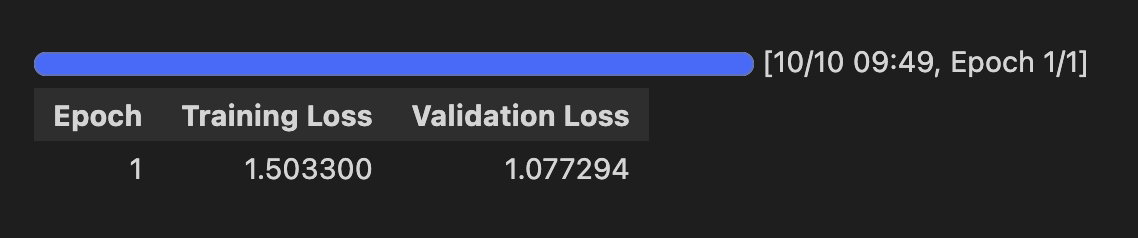

全量数据训练的运行结果:
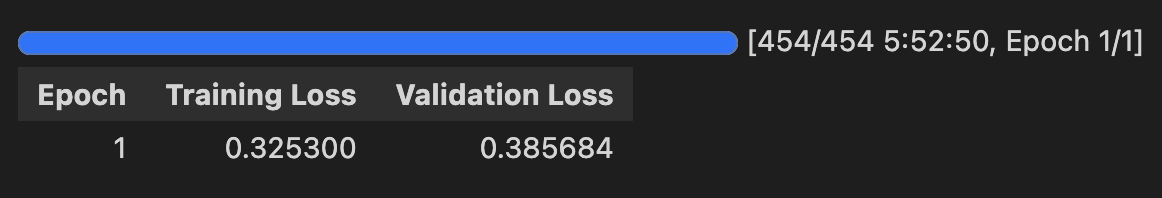

#### 显存占用(抽样训练)
```sh
Fri Aug 15 17:18:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.08             Driver Version: 550.127.08     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:07.0 Off |                    0 |
| N/A   61C    P0             61W /   70W |   13181MiB /  15360MiB |    100%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
                                                                                         
+-----------------------------------------------------------------------------------------+
| Processes:                                                                              |
|  GPU   GI   CI        PID   Type   Process name                              GPU Memory |
|        ID   ID                                                               Usage      |
|=========================================================================================|
|    0   N/A  N/A    402155      C   ...xin/miniconda3/envs/peft/bin/python      13178MiB |
+-----------------------------------------------------------------------------------------+
```

#### 显存占用(全量训练)
```sh
Sat Aug 16 15:53:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.08             Driver Version: 550.127.08     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:07.0 Off |                    0 |
| N/A   67C    P0             71W /   70W |   13017MiB /  15360MiB |    100%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
                                                                                         
+-----------------------------------------------------------------------------------------+
| Processes:                                                                              |
|  GPU   GI   CI        PID   Type   Process name                              GPU Memory |
|        ID   ID                                                               Usage      |
|=========================================================================================|
|    0   N/A  N/A    431997      C   ...xin/miniconda3/envs/peft/bin/python      13014MiB |
+-----------------------------------------------------------------------------------------+
```

### 保存 LoRA 模型(Adapter)

In [29]:
trainer.save_model(model_dir)

In [30]:
print("模型已保存到:", model_dir)

模型已保存到: models/whisper-large-v2-asr-int8


```sh
~/LLM-quickstart-exec/peft/models/whisper-large-v2-asr-int8$ ll
total 7768
drwxr-xr-x 2 wangfuxin root    4096 Aug 15 17:28 ./
drwxr-xr-x 6 wangfuxin root    4096 Aug 15 17:17 ../
-rw-r--r-- 1 wangfuxin root     697 Aug 15 17:28 adapter_config.json
-rw-r--r-- 1 wangfuxin root 7918280 Aug 15 17:28 adapter_model.safetensors
-rw-r--r-- 1 wangfuxin root     339 Aug 15 17:28 preprocessor_config.json
-rw-r--r-- 1 wangfuxin root    5096 Aug 15 17:28 README.md
-rw-r--r-- 1 wangfuxin root    4856 Aug 15 17:28 training_args.bin
```

In [31]:
peft_model.eval()

PeftModel(
  (base_model): LoraModel(
    (model): WhisperForConditionalGeneration(
      (model): WhisperModel(
        (encoder): WhisperEncoder(
          (conv1): Conv1d(80, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
          (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
          (embed_positions): Embedding(1500, 1280)
          (layers): ModuleList(
            (0-31): 32 x WhisperEncoderLayer(
              (self_attn): WhisperSdpaAttention(
                (k_proj): Linear8bitLt(in_features=1280, out_features=1280, bias=False)
                (v_proj): lora.Linear8bitLt(
                  (base_layer): Linear8bitLt(in_features=1280, out_features=1280, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=4, bias=False)
                  )
            

## 模型推理（可能需要重启 Notebook）

**再次加载模型会额外占用显存，如果显存已经达到上限，建议重启 Notebook 后再进行以下操作**


In [32]:
model_dir = "models/whisper-large-v2-asr-int8"

language = "Chinese (China)"
language_abbr = "zh-CN"
language_decode = "chinese"
task = "transcribe"


### 使用 `PeftModel` 加载 LoRA 微调后 Whisper 模型

使用 `PeftConfig` 加载 LoRA Adapter 配置参数，使用 `PeftModel` 加载微调后 Whisper 模型

In [33]:
from transformers import AutoModelForSpeechSeq2Seq, AutoTokenizer, AutoProcessor
from peft import PeftConfig, PeftModel

peft_config = PeftConfig.from_pretrained(model_dir)

base_model = AutoModelForSpeechSeq2Seq.from_pretrained(
    peft_config.base_model_name_or_path, load_in_8bit=True, device_map="auto"
)

peft_model = PeftModel.from_pretrained(base_model, model_dir)

/home/wangfuxin/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [34]:
tokenizer = AutoTokenizer.from_pretrained(peft_config.base_model_name_or_path, language=language, task=task)
processor = AutoProcessor.from_pretrained(peft_config.base_model_name_or_path, language=language, task=task)
feature_extractor = processor.feature_extractor

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### 使用 Pipeline API 部署微调后 Whisper 实现中文语音识别任务

In [35]:
test_audio = "data/audio/test_zh.flac"

In [36]:
from transformers import AutomaticSpeechRecognitionPipeline

pipeline = AutomaticSpeechRecognitionPipeline(model=peft_model, tokenizer=tokenizer, feature_extractor=feature_extractor)

forced_decoder_ids = processor.get_decoder_prompt_ids(language=language_decode, task=task)

In [37]:
import torch

with torch.cuda.amp.autocast():
    text = pipeline(test_audio, max_new_tokens=255)["text"]

/home/wangfuxin/.local/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [38]:
text

'这是一段测试用于WhisperLargeV2模型的自动语音识别测试。'

## Homework

1. 使用完整的数据集训练，对比 Train Loss 和 Validation Loss 变化。训练完成后，使用测试集进行模型评估.
2. [Optional]使用其他语种（如：德语、法语等）的数据集进行微调训练，并进行模型评估模型评估。

对比结果见训练后的Markdown单元格